# check image

In [2]:

import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot as plt


def undo_normalize_scale(im):
    mean = [1042.59240722656, 915.618408203125, 671.260559082031, 2605.20922851562]
    std = [957.958435058593, 715.548767089843, 596.943908691406, 1059.90319824218]
    im = im * std + mean
    array_min, array_max = im.min(), im.max()
    im = (im - array_min) / (array_max - array_min)
    im *= 255.0
    return im.astype(np.uint8)

def undo_normalize_scale_3(im):
    mean = [1042.59240722656, 915.618408203125, 671.260559082031]
    std = [957.958435058593, 715.548767089843, 596.943908691406]
    im = im * std + mean
    array_min, array_max = im.min(), im.max()
    im = (im - array_min) / (array_max - array_min)
    im *= 255.0
    return im.astype(np.uint8)

def show_tif(path):
    with rasterio.open(path) as image:
        image_array = image.read()

    cur_images = []
    img = rasterio.open(path)
    red = img.read(3)
    green = img.read(2)
    blue = img.read(1)
    nir = img.read(4)
    # image = np.dstack((red, green, blue, nir))
    image = np.dstack((red, green, blue))

    
    image = undo_normalize_scale_3(image)
    # image = np.array(image,dtype=float)/float(255)
    plt.imshow(image)
    plt.show()
    return image
    
def get_files_matching_pattern(directory, pattern):
    import glob
    file_list = glob.glob(directory + pattern)
    return file_list

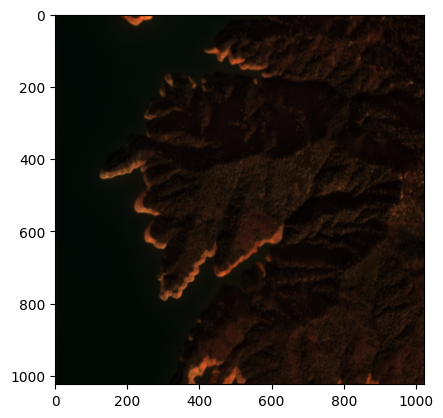

In [18]:



directory = "/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly/planet/"
pattern = "*.tif"
files_planets = get_files_matching_pattern(directory, pattern)
path_ = files_planets[1]
img = show_tif(path_)

In [1]:
# import mmcv 
# img=np.uint8(img)
# mmcv.imwrite(img, 'abc_mmcv.png')

# image = mmcv.imread('abc_mmcv.png')
# plt.imshow(image)
# plt.show()

In [2]:
# import cv2
# cv2.imwrite("abc_cv2.png", img)
# image = mmcv.imread('abc_cv2.png')
# plt.imshow(image)
# plt.show()

In [ ]:
# image = cv2.imread('/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly/planet/10N_23E-188N_1311_3077_13_PF-SR_2018-01-01.png')
# plt.imshow(image)
# plt.show()

# check label

In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot as plt
def get_files_matching_pattern(directory, pattern):
    import glob
    file_list = glob.glob(directory + pattern)
    return file_list

def color_map(N=7, normalized=False):

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)

    cmap[0] = np.array([96, 96, 96])  # impervious surface
    cmap[1] = np.array([204, 204, 0])  # agriculture
    cmap[2] = np.array([0, 204, 0])  # forest & other
    cmap[3] = np.array([0, 0, 153])  # wetland
    cmap[4] = np.array([153, 76, 0])  # soil
    cmap[5] = np.array([0, 128, 255])  # water

    #snow rgb in the paper 138, 178, 198
    cmap = cmap/255 if normalized else cmap
    return cmap
color = color_map(normalized=False)
color[0]
directory = "/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly/labels/"
pattern = "*.tif"

all_file_labels = get_files_matching_pattern(directory, pattern)

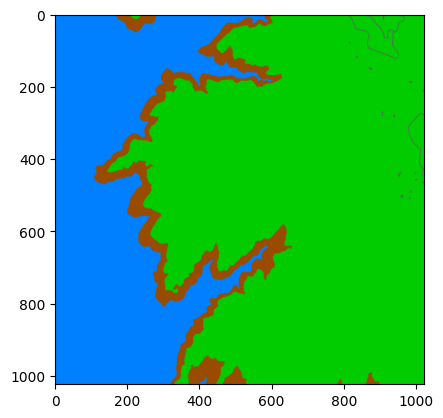

In [6]:
num_classes = 6
label = all_file_labels[0]
label  = rasterio.open(label)
label = label.read()
mask = np.zeros((label.shape[1], label.shape[2], 3), dtype=np.int32)

for i in range(num_classes+1):
    if sum(sum(label[i,:])) == 0: continue
    if i == 6:
        mask[label[i, :, :] == 255] = -1
    else:
        mask[label[i, :, :] == 255] = color[i]
#print(np.unique(mask))
plt.imshow(mask)
plt.show()

In [8]:
import mmengine.fileio as fileio
import mmcv

def loadAnnotations(path):
    img_bytes = fileio.get( path)
    gt_semantic_seg = mmcv.imfrombytes(
        img_bytes, flag='unchanged',
        backend='pillow').squeeze().astype(np.uint8)
    return gt_semantic_seg # https://mmsegmentation.readthedocs.io/en/latest/_modules/mmseg/datasets/transforms/loading.html#LoadAnnotations

#convert gray scale to color 
def decode_segmap(temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, 6):
        r[temp == l] = color[l][0]
        g[temp == l] = color[l][1]
        b[temp == l] = color[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


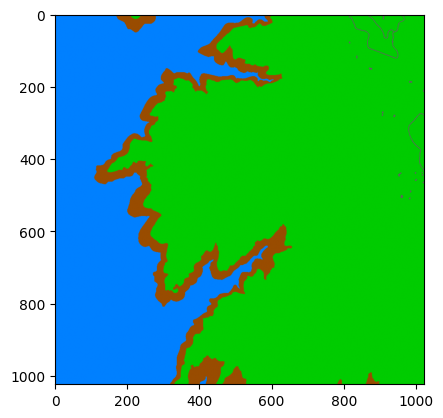

In [14]:

label_file = all_file_labels[0][:-3]+'png'
label = loadAnnotations(label_file)
label = decode_segmap(label)

plt.imshow(label)
plt.show()

# analysis pixel

In [24]:
## Read all file labels of validation
## Count pixel follow class

path_label = '/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly/splits/train.txt'
abs_path = '/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly/labels/'
with open(path_label, 'r') as f:
    datalines = f.readlines()
    all_data = [abs_path + d.strip()+'.png' for d in datalines]
len(all_data)

1031

In [32]:
results = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
for file in all_data:
    label = loadAnnotations(file)
    for i in range(6):
        count = np.count_nonzero(label==i)
        results[i] += count
        print(i, count)
    

0 1832
1 0
2 656227
3 0
4 74731
5 315786
6 0
0 1832
1 0
2 656293
3 0
4 53064
5 337387
6 0
0 1875
1 0
2 656136
3 0
4 21738
5 368827
6 0
0 1883
1 0
2 656078
3 0
4 11764
5 378851
6 0
0 1883
1 0
2 655824
3 0
4 9472
5 381397
6 0
0 1883
1 0
2 655984
3 0
4 3825
5 386884
6 0
0 0
1 0
2 2636
3 0
4 180777
5 865163
6 0
0 0
1 0
2 1513
3 0
4 376136
5 670927
6 0
0 0
1 0
2 1292
3 0
4 537705
5 509579
6 0
0 0
1 0
2 2089
3 0
4 433555
5 612932
6 0
0 0
1 0
2 1554
3 0
4 406280
5 640742
6 0
0 0
1 0
2 2523
3 0
4 563583
5 482470
6 0
0 0
1 0
2 1754
3 0
4 304227
5 742595
6 0
0 0
1 0
2 1663
3 0
4 319960
5 726953
6 0
0 0
1 0
2 1265
3 0
4 266698
5 780613
6 0
0 0
1 0
2 227
3 0
4 556772
5 491577
6 0
0 0
1 0
2 1292
3 0
4 209330
5 837954
6 0
0 0
1 0
2 6856
3 0
4 201134
5 840586
6 0
0 316791
1 0
2 518066
3 0
4 212766
5 953
6 0
0 316791
1 0
2 518066
3 0
4 212766
5 953
6 0
0 316791
1 0
2 518066
3 0
4 212766
5 953
6 0
0 316791
1 0
2 518066
3 0
4 212766
5 953
6 0
0 316791
1 0
2 518066
3 0
4 212766
5 953
6 0
0 316791
1 0
2 5

In [26]:
results


{0: 99148661,
 1: 117492699,
 2: 462203983,
 3: 2238755,
 4: 304561383,
 5: 95436375,
 6: 0}

In [31]:
validation= {0: 2348342,
    1: 30620883,
    2: 49052245,
    3: 2502685,
    4: 32897962,
    5: 8407003,
    6: 0}

train = {0: 99148661,
    1: 117492699,
    2: 462203983,
    3: 2238755,
    4: 304561383,
    5: 95436375,
    6: 0}


val = sum(validation.values())
trainn = sum(train.values())

for k,v in validation.items():
    validation[k] = 100*v/val
for k,v in train.items():
    train[k] = 100*v/trainn
validation, train

({0: 1.866294542948405,
  1: 24.335291385650635,
  2: 38.98322184880575,
  3: 1.9889553387959797,
  4: 26.144951184590656,
  5: 6.681285699208577,
  6: 0.0},
 {0: 9.171244568551893,
  1: 10.86806686726967,
  2: 42.75383778154908,
  3: 0.2070846890616949,
  4: 28.171907733876537,
  5: 8.827858359691128,
  6: 0.0})

In [28]:
sum(validation.values())

99.99999999999999

In [ ]:
+--------------------+-------+-------+
|       Class        |  IoU  |  Acc  |
+--------------------+-------+-------+
| impervious surface |  9.57 | 11.98 |
|    agriculture     |  9.27 | 10.32 |
|   forest & other   | 56.41 | 74.56 |
|      wetland       |  0.0  |  0.0  |
|        soil        | 41.87 | 87.35 |
|       water        |  7.17 |  7.86 |
+--------------------+-------+-------+